In [2]:
import sklearn.datasets
import numpy as np
x, y = sklearn.datasets.make_moons(5000, noise=0.2)

In [3]:
def activation(Z, act_type):
  if act_type == 'relu':
    return np.maximum(0, Z)
  elif act_type == 'tanh':
    return np.tanh(Z)
  elif act_type == 'sigmoid':
    return 1 / (1 + np.exp(-Z))
  elif act_type == 'l_relu':
    return np.maximum(0.01 * Z, Z)

In [4]:
def calculate_dz(Z, dA, act_type):
  if act_type == 'relu':
    dZ = np.array(dA, copy=True) # just converting dz to a correct object.
    dZ[Z <= 0] = 0
    return dZ
  elif act_type == 'tanh':
    s = np.tanh(Z)
    return dA * (1 - np.power(s, 2))
  elif act_type == 'sigmoid':
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    return dZ
  elif act_type == 'l_relu':
    dZ = np.zeros((dA.shape)) # just converting dz to a correct object.
    dZ[Z <= 0] = 0.01
    dZ[Z > 0] = 1
    return dZ * dA

In [13]:
from matplotlib import pyplot as plt
def plot_with_test_data(forward):
  A = forward(X_test.T)
  h = .02  # step size in the mesh
  x_min, x_max = X_test[:, 0].min() - 1, X_test[:, 0].max() + 1
  y_min, y_max = X_test[:, 1].min() - 1, X_test[:, 1].max() + 1
  xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                np.arange(y_min, y_max, h))
  Z = forward(np.c_[xx.ravel(), yy.ravel()].T)
  Z = Z.reshape(xx.shape)
  plt.scatter(X_test[:,0], X_test[:,1], c=(A > 0.5).astype(int).T)
  plt.contourf(xx, yy, (Z > 0.5), alpha=0.3)
  plt.show()

In [11]:
class NeuralNet():
  def __init__(self, lr, layers, lamd):
    self.layers = layers
    self.lr = lr
    self.params = {}
    self.grads = {}
    self.cache = []
    self.lamd = lamd

  def init_params(self):
    for i in range(1, len(self.layers)):
      self.params["W" + str(i)] = np.random.randn(self.layers[i][0], self.layers[i - 1][0]) / np.sqrt(self.layers[i - 1][0])
      self.params["b" + str(i)] = np.zeros((self.layers[i][0], 1))

  def forward(self, X):
    A = X
    self.cache = []
    for i in range(1, len(self.layers)):
      W = self.params["W" + str(i)]
      b = self.params["b" + str(i)]

      Z = np.dot(W, A) + b
      self.cache.append((W, A, Z))
      A = activation(Z, self.layers[i][1])

    return A

  def cost(self, A, Y):
    m = Y.shape[1]
    # Compute loss from aL and y.
    cost = (-np.dot(Y,np.log(A).T) - np.dot(1-Y, np.log(1-A).T))
    cost_reg = 0
    for l in range(len(layers) - 1):
      cost_reg += self.lamd * np.sum(self.params["W" + str(l + 1)] * self.params["W" + str(l + 1)])
    cost_reg = np.squeeze(cost_reg) * 0.5 / m
    cost = np.squeeze(cost) / m     # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
    assert(cost.shape == ())
    return cost + cost_reg

  def backprop(self, A, Y):
    self.grads = {}
    L = len(self.cache) # the number of layers
    m = A.shape[1]
    Y = Y.reshape(A.shape) # after this line, Y is the same shape as AL
    #dA = - (np.divide(Y, A) - np.divide(1 - Y, 1 - A))
    self.grads["dA" + str(L)] = - (np.divide(Y, A) - np.divide(1 - Y, 1 - A))
    for l in reversed(range(L)):
      self.backprop_for_layer(l, self.grads["dA" + str(l + 1)], self.layers[l + 1][1])

  def backprop_for_layer(self, index, dA, activation):
    m = dA.shape[1]
    W, A_prev, Z = self.cache[index]
    dZ = calculate_dz(Z, dA, activation)
    dW = 1./m * (np.dot(dZ,A_prev.T) + self.lamd * W)
    db = 1./m * np.sum(dZ, axis = 1, keepdims = True)
    dA_prev = np.dot(W.T,dZ)
    self.grads["dA" + str(index)] = dA_prev
    self.grads["dW" + str(index + 1)] = dW
    self.grads["db" + str(index + 1)] = db

  def update_weights(self):
    for l in range(1, len(layers)):
      self.params["W" + str(l)] = self.params["W" + str(l)] - self.lr * self.grads["dW" + str(l)]
      self.params["b" + str(l)] = self.params["b" + str(l)] - self.lr * self.grads["db" + str(l)]

  def train(self, epochs, X, Y):
    cost_old = 1000
    self.init_params()
    for i in range(epochs):
      A = self.forward(X)
      cost = self.cost(A, Y)
      self.backprop(A, Y)
      self.update_weights()
      if(i % 100 == 0):
        print("Loss: ", cost, " at epoch: ", i)
        plot_with_test_data(self.forward)
      if(cost < 0.01):
        return self.params, self.grads
    return self.params, self.grads

In [6]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=0)

In [7]:
layers = [(2, ""), (20, 'l_relu'), (50, 'l_relu'), (5, 'l_relu'), (1, 'sigmoid')]
epochs = 1500
lr = 0.1
lamd = 0
X = X_train.T
Y = y_train.reshape(1, -1)

Loss:  0.7507940443776803  at epoch:  0


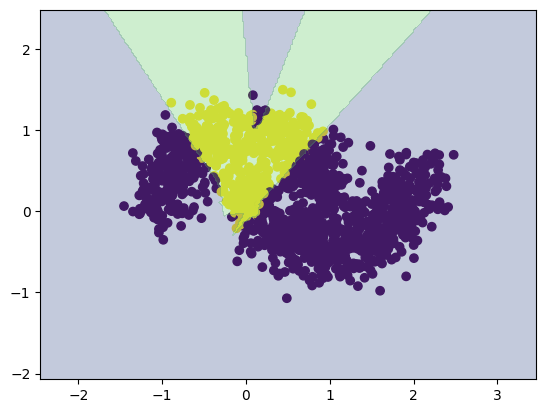

Loss:  0.45298498707186885  at epoch:  100


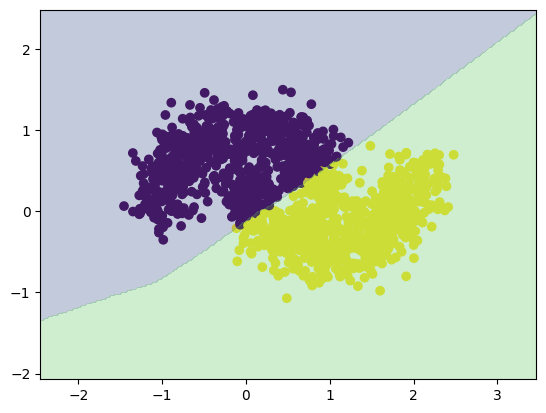

Loss:  0.3551881458492947  at epoch:  200


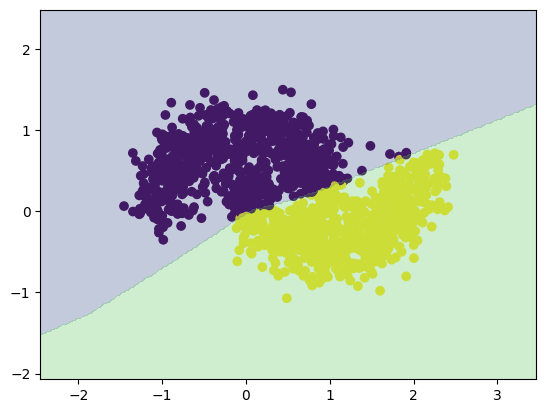

Loss:  0.3032569144890659  at epoch:  300


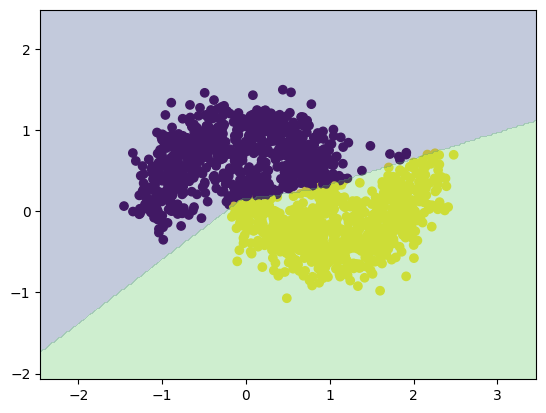

Loss:  0.23706556455610417  at epoch:  400


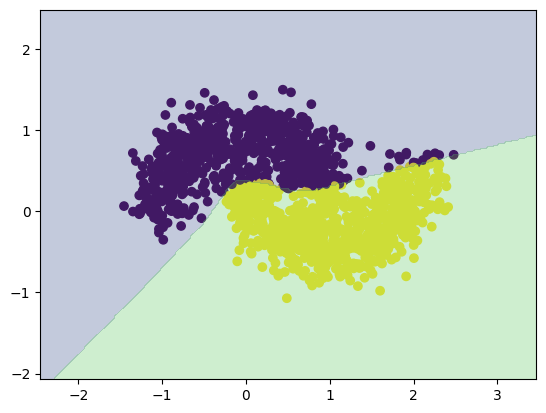

Loss:  0.1850398356445512  at epoch:  500


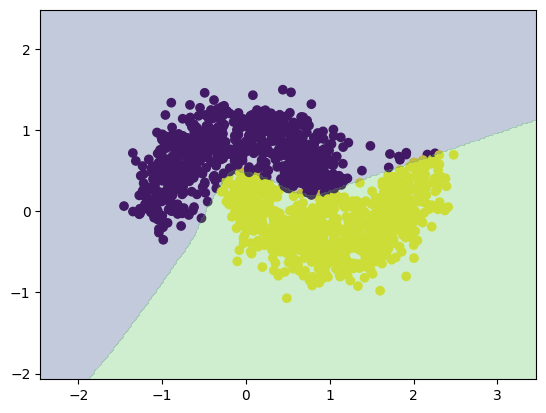

Loss:  0.14194041323017237  at epoch:  600


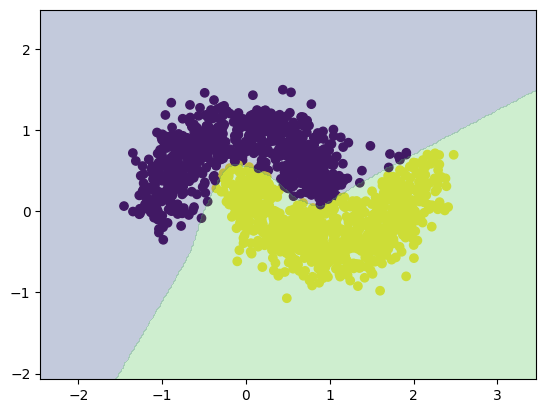

Loss:  0.11201312007050193  at epoch:  700


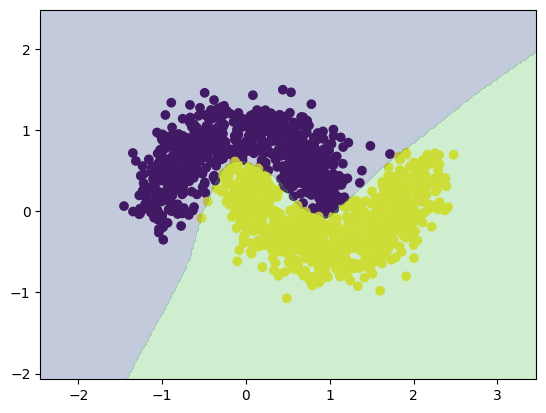

Loss:  0.09711118384619402  at epoch:  800


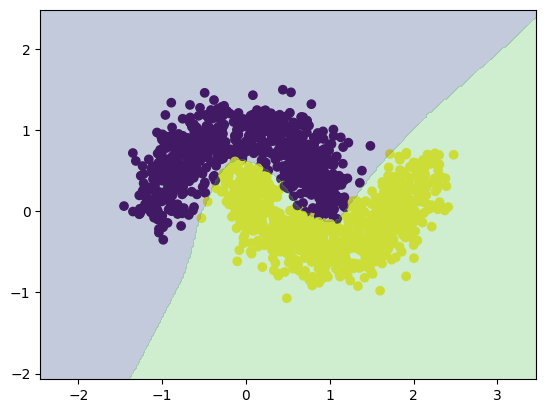

Loss:  0.09124936578642132  at epoch:  900


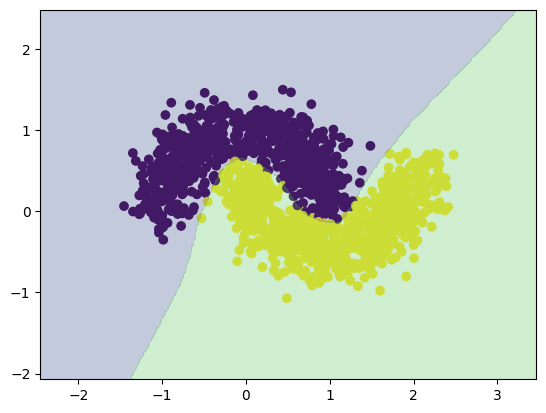

Loss:  0.0882296929838616  at epoch:  1000


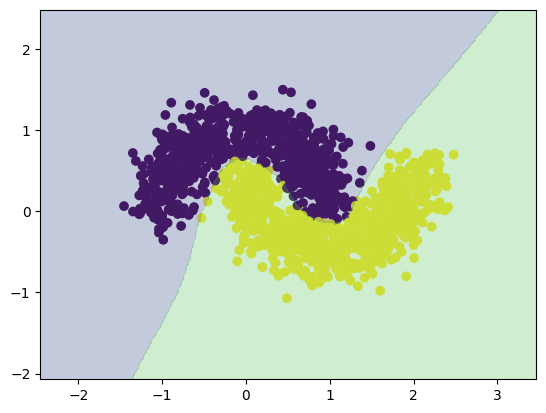

Loss:  0.08662477736343568  at epoch:  1100


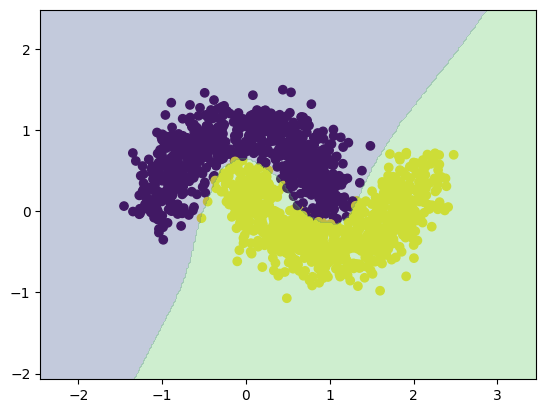

Loss:  0.08552947697267058  at epoch:  1200


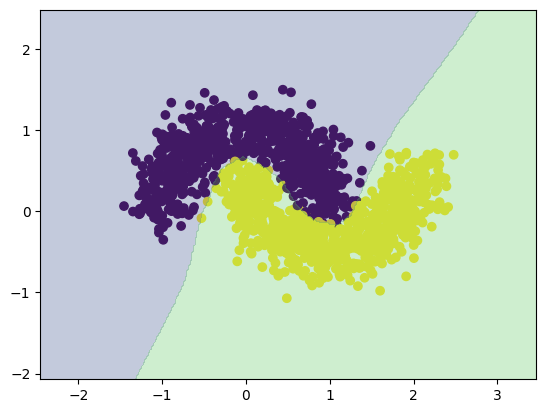

Loss:  0.0846772165331536  at epoch:  1300


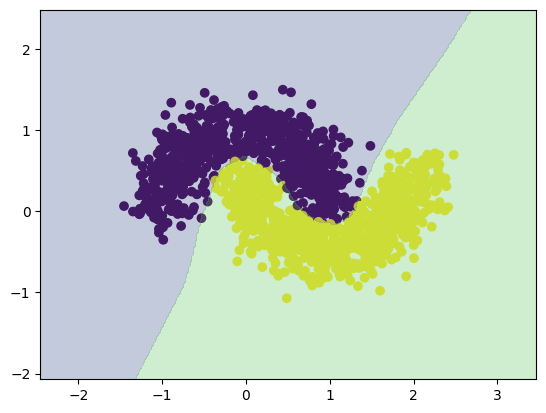

Loss:  0.08419380789411716  at epoch:  1400


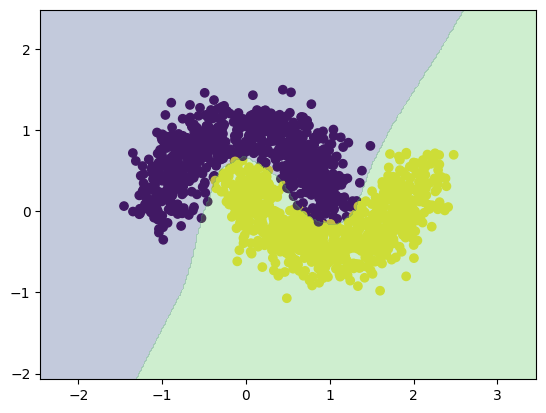

In [14]:
model = NeuralNet(lr, layers, lamd)
params, grads = model.train(epochs, X, Y)

In [ ]:
import sklearn.metrics
A = model.forward(X_test.T)
print(sklearn.metrics.classification_report(y_test.T, (A > 0.5).astype(int).T))
print(sklearn.metrics.accuracy_score(y_test.T, (A > 0.5).astype(int).T))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       749
           1       0.97      0.97      0.97       751

    accuracy                           0.97      1500
   macro avg       0.97      0.97      0.97      1500
weighted avg       0.97      0.97      0.97      1500

0.9666666666666667


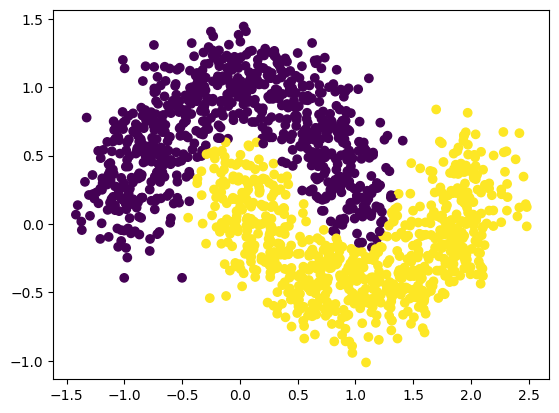

In [ ]:
from matplotlib import pyplot as plt

A = model.forward(X_test.T)
plt.scatter(X_test[:,0], X_test[:,1], c=(A > 0.5).astype(int).T)